<a href="https://colab.research.google.com/github/WesRobbins/AdversarialML/blob/main/Fashion_MNIST_Exploratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examination of Exploratory Attacks and Defenses on the MNIST Dataset

changes to the colab notebook

##Overview
The focus of this Colab Notebook will be to examine exploratory attacks and how effective certain defenses are against these attacks. Specifically we will be looking at the Fast Gradient Sign Method (FGSM) attack and the "black box" attack, which is a modified version of FGSM. For our experiments we will be utilizing a convolutional neural network trained on the fashion_mnist dataset.

###Fashion_MNIST Dataset
- 10 classes associated with different clothing items
- 60,000 training examples
- 10,000 testing examples
- 28 x 28 grayscale images

#Attacks
###Normal FGSM Attack
Proposed in Goodfellow et al. 2015 [[4]](https://arxiv.org/pdf/1412.6572.pdf) <br/>
For this experiment, we altered all of the testing data image by image. This works by sending the image through the neural network and using the prediction vector to compute loss. Using the loss we can find the gradient that gets sent back through the weights and "perturb" our image in the opposite direction by a very small amount. This results in a test set that visually appears unaltered but has significant affects on model performance.

### Random FGSM 
Proposed in Tramer et al. 2017 [[5]](https://arxiv.org/pdf/1705.07204.pdf) <br/>
This attack is similar to FGSM with the exception that it takes does a small random perturbation before doing the gradient based perturbation.

###"Black Box" Attack
The Black Box attack functions very similarly to FGSM, except it is useful when the attacker does not have access to certain information about the original model, namely the gradient. In this case, the attacker can use predictions from the original model to create a new model that they have full control on. Then, using the gradient for this separate model, they can construct adversial inputs using the FGSM method that can still fool the original model, albeit to a reduced extent.

#Defenses


##Code
Below we have our code that these experiments are run on. This includes model construction, preprocessing our data, and implementation of attacks/defenses. Our models run on the keras/tensorflow API's.

In [3]:
#Necessary imports for future code
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from datetime import datetime
import matplotlib.image as mpimg
import sys
import numpy as np
import random as rand
import os
import csv
import urllib
from importlib import reload
from termcolor import colored
import seaborn as sns
import pandas as pd
import copy
import glob
import imageio
import PIL
import time
from keras.constraints import Constraint
from IPython import display
from keras import backend

In [18]:
def load_run_save(arry, ds_name, v=0,multi_dim=False, **kwargs):
  if not multi_dim:
    saved.arrys[arry].clear()
    for eps in epsilon:
      print(f'{arry} - EPS: {eps}')
      saved.arrys[arry].append(load_and_run(ds_name, epsilon=eps, show=False, **kwargs))
      if (v == 2):
        print('++++++++++++++++++++++++')
        print(f'through dict: {saved.arrys[arry]}')
        print(f'direct: {saved.fashion_fgsm}')

    print(colored(f'{arry} array updated', 'green'))
  else:
    saved.arrys2d[arry].clear()
    for dim in multi_dim:
      print(f'Dimension is {dim}')
      row = []
      for eps in epsilon:
        print(f'{arry} - EPS: {eps}')
        row.append(load_and_run(ds_name, epsilon=eps, iters=dim, show=False, **kwargs))
      saved.arrys2d[arry].append(row)
      





def load_and_run(ds_name, black_box=False, attack=None, epsilon=None, defense=None, retrain=False, QS=None, show=True, iters=None):
  (ds_train, ds_test), ds_info = tfds.load(
    ds_name,
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
  
  def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def gan_normalize_img2(image, label):
  return (tf.cast(image, tf.float32) - 127.5)/127.5, label


  #Preprocessing training data
  if defense == 'DefenseGAN':
    ds_train = ds_train.map(
        gan_normalize_img2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  else:  
    ds_train = ds_train.map(
        normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_train = ds_train.cache()
  ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
  ds_train = ds_train.batch(128)
  ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

  #Preprocessing testing data
  ds_test = ds_test.map(
      normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  ds_test = ds_test.batch(128)
  ds_test = ds_test.cache()
  ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

  #Constructs and trains the model
  model = construct_model()
  name = "model/trained"+ds_name

  if retrain==True:
    model.fit(ds_train, epochs=15)
    model.save_weights(name)
  else:
    if os.path.isfile(name+".index")==True:
      model.load_weights(name).expect_partial()
    else:
      print('Model Weights Not Found. Retraining Model.')
      model.fit(ds_train, epochs=15)
      model.save_weights(name)

  # Apply defensive technique
  AUTOTUNE = tf.data.experimental.AUTOTUNE
  adv_tr_epochs = 6
  if defense == 'adv-training' or defense == 'adv-trainingR':
    print('Making adversarinal training images...')
    if defense == 'adv-trainingR':
      fgsm_train = fgsm(ds_train, model, 'R')
      defense = 'adv-training'
    else:
      fgsm_train = fgsm(ds_train, model, epsilon)
    print('Training model on adversarial images(8 epochs)...')
    model2 = construct_model()
    adv_train = ds_train.concatenate(fgsm_train)
    adv_train = adv_train.shuffle(ds_info.splits['train'].num_examples)
    model2.fit(adv_train, epochs=8, verbose=0)
  elif defense == 'adv-training5':
    model2 = construct_model()
    fgsm_train = fgsm(ds_train, model, epsilon)
    adv_train = ds_train.concatenate(fgsm_train)
    adv_train = adv_train.shuffle(ds_info.splits['train'].num_examples)
    print(f'Training on Adversarial Imgs({adv_tr_epochs} epochs)... Iteration 1 of 5')
    model2.fit(adv_train, epochs=adv_tr_epochs, verbose=0)
    for i in range(4):
      fgsm_train = fgsm(ds_train, model2, epsilon)
      adv_train = ds_train.concatenate(fgsm_train)
      adv_train = adv_train.shuffle(ds_info.splits['train'].num_examples)
      print(f'Training on Adversarial Imgs({adv_tr_epochs} epochs)... Iteration {i+2} of 5')
      model2.fit(adv_train, epochs=adv_tr_epochs, verbose=0)
  elif defense == 'adv-training-iter':
    model2 = construct_model()
    fgsm_train = fgsm(ds_train, model, epsilon)
    adv_train = ds_train.concatenate(fgsm_train)
    adv_train.prefetch(AUOTNUE)
    print(f'Training on Adversarial Imgs({adv_tr_epochs} epochs)... Iteration 1 of {iters}')
    model2.fit(adv_train, epochs=adv_tr_epochs, verbose=0)
    for i in range(iters-1):      
      fgsm_train = fgsm(ds_train, model2, epsilon)
      adv_train = ds_train.concatenate(fgsm_train)
      adv_train = adv_train.shuffle(ds_info.splits['train'].num_examples)
      print(f'Training on Adversarial Imgs({adv_tr_epochs} epochs)... Iteration {i+2} of {iters}')
      model2.fit(adv_train, epochs=adv_tr_epochs, verbose=0)
  elif defense == 'adv-trainingf-iter':
    model2 = construct_model()
    fgsm_train = fgsm(ds_train, model, epsilon)
    adv_train = ds_train.concatenate(fgsm_train)
    adv_train = adv_train.shuffle(ds_info.splits['train'].num_examples)
    adv_train = adv_train.cache()
    adv_train.prefetch(AUTOTUNE)
    print(f'Training on Adversarial Imgs({adv_tr_epochs} epochs)... Iteration 1 of {iters}')
    model2.fit(adv_train, epochs=adv_tr_epochs, verbose=0)
    for i in range(iters-1):
      print('start')
      ds_train = ds_train.shuffle(400)
      adv_train = ds_train.take(40)   
      fgsm_train = fgsm(ds_train.take(40), model2, epsilon)
      adv_train = adv_train.concatenate(fgsm_train)
      adv_train = adv_train.shuffle(80)
      adv_train = adv_train.cache()
      adv_train.prefetch(AUTOTUNE)
      print(f'Training on Adversarial Imgs({1} epochs)... Iteration {i+2} of {iters}')
      model2.fit(adv_train, epochs=1, verbose=1)

  elif defense == 'DefenseGAN':
    print("Beginning defense-Gan reconstructiontion...")
    ds_test = defenseGAN_reconstruct(ds_train)
    print('Back from reconstruction')


      
      


    
  # Creates black box 
  if black_box:
    if attack == 'fgsm2':
      box_model2 = create_black_box(adv_train, model2, QS)
    else:
      box_model = create_black_box(ds_train, model, QS)

  #Perturbs the testing data via fgsm method
  if attack == "fgsm":
    if not black_box:
      ds_test = fgsm(ds_test, model, epsilon)
    elif black_box:
      ds_test = fgsm(ds_test, box_model, epsilon)
  elif attack == 'fgsm2':
    if not black_box:
      ds_test = fgsm(ds_test, model2, epsilon)
    elif black_box:
      ds_test = fgsm(ds_test, box_model2, epsilon)
  elif attack == 'rand+fgsm':
    if not black_box:
      ds_test = rand_fgsm(ds_test, model2, epsilon)
    elif black_box:
      ds_test = rand_fgsm(ds_test, box_model2, epsilon)
    
  #Displays first 5 images of testing data
  if show:
    show_images(ds_test)
  
  print()
  print("Evaluation: ")

  if defense[:12] == 'adv-training':
    print('With adversarial training:', end=' ')
    results = model2.evaluate(ds_test, verbose=2)[1]
    print('Without adversarial training:')
    print(model.evaluate(ds_test)[1])
  
  else:
    results = model.evaluate(ds_test, verbose=2)[1]

  return results

def construct_model():
  """Builds the architecture of Neural Network"""
  model = keras.Sequential([
          keras.layers.Conv2D(32, 3, activation='relu'),
          #keras.layers.BatchNormalization(),
          #keras.layers.Conv2D(32, 3, activation='relu'),
          #keras.layers.BatchNormalization(),
          #keras.layers.Conv2D(32, 5, 2, activation='relu', padding='same'),
          keras.layers.Dropout(0.4),
          keras.layers.Flatten(),
          keras.layers.Dense(128, activation='relu'),
          keras.layers.Dense(10, activation='softmax')

  ])

  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])
  return model

def show_images(ds):
  """Displays 5 images from the dataset passed into it"""
  ds_numpy = tfds.as_numpy(ds.unbatch())
  imgs = []
  for img in ds_numpy:
    imgs.append(np.squeeze(img[0]))
    if len(imgs) >= 5:
      break
  plt.figure(figsize=(20,10))
  columns = 5
  for i, image in enumerate(imgs):
    plt.subplot(len(imgs) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap='gray')

  plt.show()


def show_img(img):
  img = np.squeeze(img.numpy())
  plt.imshow(img, cmap='gray')
  plt.show()

def show_2img(img1, img2):
  img1 = np.squeeze(img1.numpy())
  img2 = np.squeeze(img2.numpy())
  plt.subplot(1,2,1)
  plt.imshow(img1, cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(img2, cmap='gray')
  plt.show()




In [12]:
def fgsm(ds_test, model, epsilon):
  """Takes in a dataset and a model, and uses the gradient of that model to alter the images of the dataset.
  Then returns the perturbed images as a new dataset"""
  imgs = []
  labels = []
  random = False
  if epsilon == 'R': 
    random = True
    print('Epsilon set to Random (0-.1)')
  for image, label in ds_test.take(-1):
      if random:
        epsilon = rand.randrange(1,100)/1000
      perturbations = create_adversarial_pattern(image, label, model)
      adv_x = image + epsilon * perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      imgs.append(adv_x)
      labels.append(label)
      
  imgs = np.concatenate(imgs)
  labels = np.concatenate(labels)
  ds = tf.data.Dataset.from_tensor_slices((imgs, labels))
  ds = ds.batch(128)
  return ds

def rand_fgsm(ds_test, model, epsilon):
  """Takes in a dataset and a model, and uses the gradient of that model to alter the images of the dataset.
  Then returns the perturbed images as a new dataset"""
  alpha = .2 # percantage of epsilon that is for random perterbation
  imgs = []
  labels = []
  random = False
  if epsilon == 'R': 
    random = True
    print('Epsilon set to Random (0-.1)')
  for image, label in ds_test.take(-1):
      if random:
        epsilon = rand.randrange(1,100)/1000
      perturbations = create_adversarial_pattern(image, label, model)
      adv_x1 = image + epsilon*alpha*np.sign(random.randn(image.size)) # take random step before grad step
      adv_x = adv_x1 + epsilon*(1-alpha) * perturbations
      adv_x = tf.clip_by_value(adv_x, -1, 1)
      imgs.append(adv_x)
      labels.append(label)
      
  imgs = np.concatenate(imgs)
  labels = np.concatenate(labels)
  ds = tf.data.Dataset.from_tensor_slices((imgs, labels))
  ds = ds.batch(128)
  return ds

def create_adversarial_pattern(input_image, input_label, pretrained_model):
  loss_object = tf.keras.losses.CategoricalCrossentropy()
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    data = input_label.numpy()
    shape = (data.size, data.max()+1)
    one_hot = np.zeros(shape)
    rows = np.arange(data.size)
    one_hot[rows, data] = 1
    input_label = tf.convert_to_tensor(one_hot)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

def create_black_box(ds_train, pretrained_model, QS=None):
  imgs = []
  labels = []
  if QS != None:
    ds_train = ds_train.unbatch()
    ds_train = ds_train.take(QS)
    ds_train = ds_train.batch(128)
  

  for example, label in iter(ds_train):
    imgs.append(example)
    predictions = pretrained_model.predict(example)
    predictions = predictions.argmax(1)
    labels.append(predictions)
  imgs = np.concatenate(imgs)
  labels = np.concatenate(labels)
  ds = tf.data.Dataset.from_tensor_slices((imgs, labels))
  model = construct_model()
  ds = ds.batch(128)
  print('Black Box Training(15 epochs)...')
  print(f'data size: {ds.cardinality()}')
  model.fit(ds, epochs=15, verbose=0)
  return model

#Experiments


In [ ]:
load_run_save('fashion_fgsm','fashion_mnist', black_box=False, attack='fgsm', show=False)
load_run_save('fashion_fgsm_box','fashion_mnist', black_box=True, attack='fgsm', show=False)
load_run_save('mnist_fgsm','mnist', black_box=False, attack='fgsm', show=False)
load_run_save('mnist_fgsm_box','mnist', black_box=True, attack='fgsm', show=False)
load_run_save('cifar_fgsm','cifar10', black_box=False, attack='fgsm', show=False)
load_run_save('cifar_fgsm_box','cifar10', black_box=True, attack='fgsm', show=False)

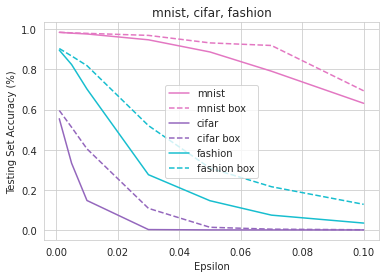

In [ ]:
sns.set_style('whitegrid')

plt.plot(epsilon, saved.arrys['mnist_fgsm'], color='C6')
plt.plot(epsilon, saved.arrys['mnist_fgsm_box'], color='C6', linestyle='--')
plt.plot(epsilon, saved.arrys['cifar_fgsm'], color='C4')
plt.plot(epsilon, saved.arrys['cifar_fgsm_box'], color='C4', linestyle='--')
plt.plot(epsilon, saved.arrys['fashion_fgsm'], color='C9')
plt.plot(epsilon, saved.arrys['fashion_fgsm_box'], color='C9', linestyle='--')
plt.legend(["mnist", "mnist box", "cifar", "cifar box", "fashion", "fashion box"])
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.title('mnist, cifar, fashion')
plt.show()

# Examining Black Box Query Strength
The above black box attack assumes the adversary has unlimited queries to reverse engineer the original model. In reality this may not be the case. The below graph show the effectivess of black box FGSM Attack when we limit the number of queries.

In [ ]:
epsilon = [.001, .005, .01, .03, .05, .07, .1]
queryStrengths  = [100, 500, 1000, 3000, 5000, 15000, 30000, None]
saved.fashion_graph.clear()
for qs in queryStrengths:
  print(f"Query Stregnth: {qs}")
  accs = []
  for eps in epsilon:
    print(f"epsilon: {eps}")
    accs.append(load_and_run('fashion_mnist', black_box=True, QS=qs, attack='fgsm', epsilon=eps, show=False))
  saved.fashion_graph.append(accs)
  print()

In [ ]:
epsilon = [.001, .005, .01, .03, .05, .07, .1]
queryStrengths  = [100, 500, 1000, 3000, 5000, 15000, 30000, None]
saved.mnist_graph.clear()
for qs in queryStrengths:
  print(f"Query Stregnth: {qs}")
  accs = []
  for eps in epsilon:
    print(f"epsilon: {eps}")
    accs.append(load_and_run('mnist', black_box=True, QS=qs, attack='fgsm', epsilon=eps, show=False))
  saved.mnist_graph.append(accs)
  print()

In [ ]:
queryStrengths  = [100, 500, 1000, 3000, 5000, 15000, 30000, None]
saved.cifar_graph.clear()
for qs in queryStrengths:
  print(f"Query Stregnth: {qs}")
  accs = []
  for eps in epsilon:
    print(f"epsilon: {eps}")
    accs.append(load_and_run('cifar10', black_box=True, QS=qs, attack='fgsm', epsilon=eps, show=False))
  saved.cifar_graph.append(accs)
  print()

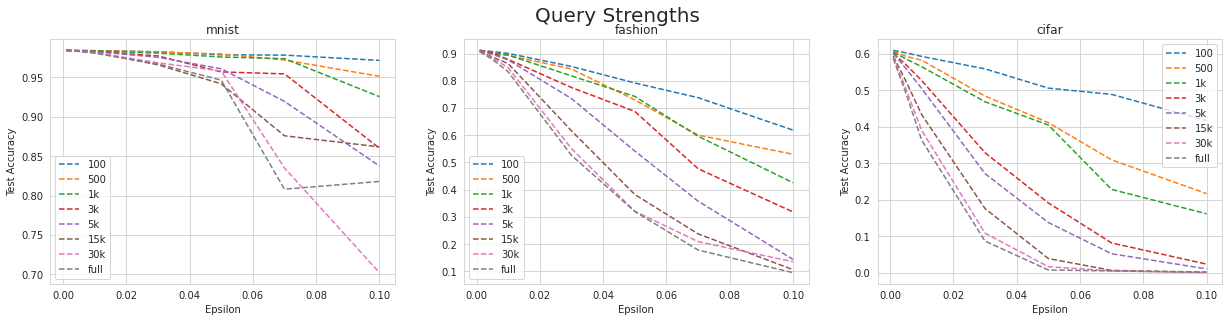

In [ ]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(21,4.5))
fig.suptitle('Query Strengths', fontsize=20)
for pl, graph in zip([plt1, plt2, plt3], [saved.arrys2d['mnist_qs'], saved.arrys2d['fashion_qs'], saved.arrys2d['cifar_qs']]):
  for strength in graph:
    pl.plot(epsilon, strength, linestyle='--')
  pl.legend(['100', "500", "1k", "3k", "5k","15k","30k", "full"])
  plt.setp(pl, xlabel='Epsilon', ylabel='Test Accuracy')
plt1.title.set_text('mnist')
plt2.title.set_text('fashion')
plt3.title.set_text('cifar')
plt.show()


#ADV-Training Defense

The adversarial training defense involves the following steps:
1. Create adversarial instances on the model
2. retrain a new model on an new dataset containing both the adverarial instances and the original dataset

From our original experimentation we show that this is a very strong defense assuming the model knows the type of adversarial input will get(strong assumption). However, as we show in our next experiment this defense can be easily beaten if the adversary recreates adversarial input based on the model created in step 2. 

(Below is TODO - these are the results I am expecting)<br/>
However, the defense can counter this counter by recreating and retraining adversarial inputs. <br/>

This could potentially become a cat and mouse game where the defender is always retraining on new adversarial inputs while the defender is always creating new adversarial inputs. 

### FGSM vs Adversarial Training 

In [ ]:
load_run_save('training_vs_fgsm','fashion_mnist', attack='fgsm', defense='adv-training')
load_run_save('training_vs_fgsm_box','fashion_mnist', black_box=True, attack='fgsm', defense='adv-training')

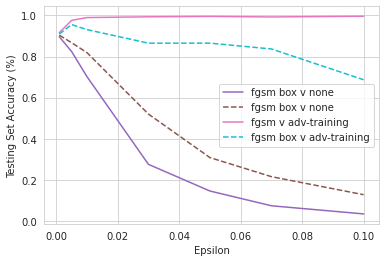

In [ ]:
plt.plot(epsilon, saved.arrys['fashion_fgsm'], color='C4')
plt.plot(epsilon, saved.arrys['fashion_fgsm_box'], color='C5', linestyle='--')
plt.plot(epsilon, saved.arrys['training_vs_fgsm'], color='C6')
plt.plot(epsilon, saved.arrys['training_vs_fgsm_box'], color='C9', linestyle='--')
plt.legend(["fgsm box v none", 'fgsm box v none',"fgsm v adv-training", 'fgsm box v adv-training'])
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.show()

### Adversary Epsilon Unknown to Model

In [ ]:
load_run_save('trainingR_vs_fgsm','fashion_mnist', attack='fgsm', defense='adv-trainingR', v=2)
load_run_save('trainingR_vs_fgsm_box','fashion_mnist', black_box=True, attack='fgsm', defense='adv-trainingR')

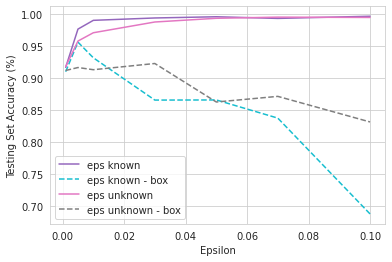

In [ ]:
plt.plot(epsilon, saved.arrys['training_vs_fgsm'], linestyle='-', color='C4')
plt.plot(epsilon, saved.arrys['training_vs_fgsm_box'], linestyle='--', color='C9')
plt.plot(epsilon, saved.arrys['trainingR_vs_fgsm'], linestyle='-', color='C6')
plt.plot(epsilon, saved.arrys['trainingR_vs_fgsm_box'], linestyle='--', color='C7')
plt.legend(["eps known", "eps known - box", "eps unknown", "eps unknown - box"])
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.show()

### 2 Layer FGSM Attack
In the above plots we see that adversarial training was very effective against fgsm images. However, this assumed that the adversary created adversarial images before the model re-trained on its own adversarial images. If the adversary has continuous access to the weights he can recreate his input after the adversarial-training defense is applied.(more importantly train his model with fgsm1 examples)

In [ ]:
load_run_save('training_vs_fgsm2','fashion_mnist', black_box=False, attack='fgsm2', defense='adv-training')
load_run_save('training_vs_fgsm2_box','fashion_mnist', black_box=True, attack='fgsm2', defense='adv-training')

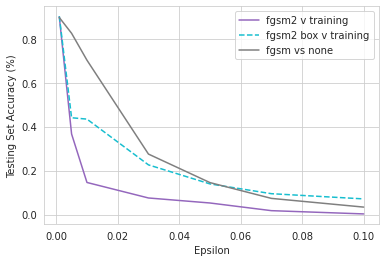

In [ ]:
plt.plot(epsilon, saved.arrys['training_vs_fgsm2'], color='C4')
plt.plot(epsilon, saved.arrys['training_vs_fgsm2_box'], linestyle='--', color='C9')
plt.plot(epsilon, saved.arrys['fashion_fgsm'], color='C7')
plt.legend(["fgsm2 v training", "fgsm2 box v training", 'fgsm vs none'])
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.show()

### Iterative Adversarial Training

In [ ]:
load_run_save('training5_vs_fgsm2','fashion_mnist', black_box=False, attack='fgsm2', defense='adv-training5')
load_run_save('training5_vs_fgsm2_box','fashion_mnist', black_box=True, attack='fgsm2', defense='adv-training5')

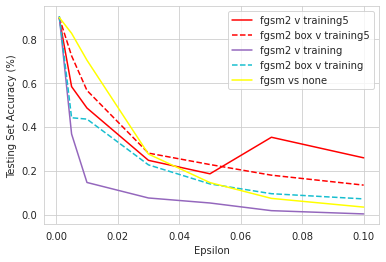

In [ ]:
plt.plot(epsilon, saved.arrys['training5_vs_fgsm2'], color='red')
plt.plot(epsilon, saved.arrys['training5_vs_fgsm2_box'], color='red', linestyle='--')
plt.plot(epsilon, saved.arrys['training_vs_fgsm2'], color='C4')
plt.plot(epsilon, saved.arrys['training_vs_fgsm2_box'], linestyle='--', color='C9')
plt.plot(epsilon, saved.arrys['fashion_fgsm'], color='yellow')
plt.legend(["fgsm2 v training5","fgsm2 box v training5","fgsm2 v training", "fgsm2 box v training", 'fgsm vs none'])
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.show()

In [ ]:
load_run_save('training20_vs_fgsm2','fashion_mnist', black_box=False, attack='fgsm2', defense='adv-training-iter', iters=20)
load_run_save('training20_vs_fgsm2_box','fashion_mnist', black_box=True, attack='fgsm2', defense='adv-training-iter', iters=20)
sfdgdfg

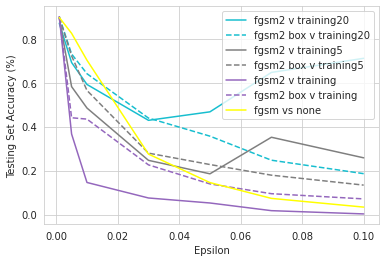

In [ ]:
plt.plot(epsilon, saved.arrys['training20_vs_fgsm2'], color='C9')
plt.plot(epsilon, saved.arrys['training20_vs_fgsm2_box'], color='C9', linestyle='--')
plt.plot(epsilon, saved.arrys['training5_vs_fgsm2'], color='C7')
plt.plot(epsilon, saved.arrys['training5_vs_fgsm2_box'], color='C7', linestyle='--')
plt.plot(epsilon, saved.arrys['training_vs_fgsm2'], color='C4')
plt.plot(epsilon, saved.arrys['training_vs_fgsm2_box'], linestyle='--', color='C4')
plt.plot(epsilon, saved.arrys['fashion_fgsm'], color='yellow')
plt.legend(["fgsm2 v training20","fgsm2 box v training20","fgsm2 v training5","fgsm2 box v training5","fgsm2 v training", "fgsm2 box v training", 'fgsm vs none'])
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.show()

In [ ]:
load_run_save('trainingf14_vs_fgsm2','fashion_mnist', black_box=False, attack='fgsm2', defense='adv-trainingf-iter', iters=14)
load_run_save('trainingf14_vs_fgsm2_box','fashion_mnist', black_box=True, attack='fgsm2', defense='adv-trainingf-iter', iters=14)

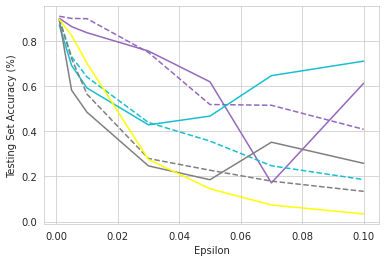

In [ ]:
plt.plot(epsilon, saved.arrys['trainingf14_vs_fgsm2'], color='C4')
plt.plot(epsilon, saved.arrys['trainingf14_vs_fgsm2_box'], color='C4', linestyle='--')
plt.plot(epsilon, saved.arrys['training20_vs_fgsm2'], color='C9')
plt.plot(epsilon, saved.arrys['training20_vs_fgsm2_box'], color='C9', linestyle='--')
plt.plot(epsilon, saved.arrys['training5_vs_fgsm2'], color='C7')
plt.plot(epsilon, saved.arrys['training5_vs_fgsm2_box'], color='C7', linestyle='--')
plt.plot(epsilon, saved.arrys['fashion_fgsm'], color='yellow')
plt.xlabel("Epsilon")
plt.ylabel("Testing Set Accuracy (%)")
plt.show()

# Defense-GAN
Proposed by Samangouei et al. 2018 [[1]](https://arxiv.org/pdf/1805.06605.pdf)

epoch 50
Gen loss: -0.32712677121162415 Disc loss: -0.0012142531340941787


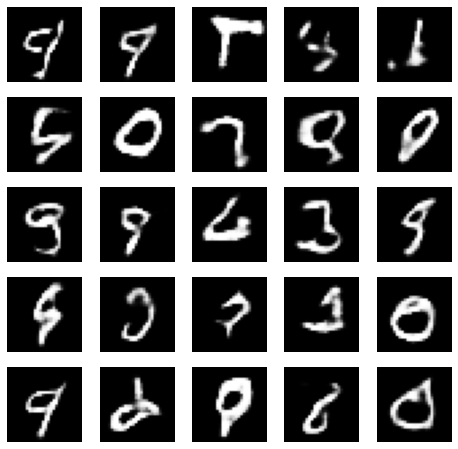

In [9]:
class ClipConstraint(Constraint):
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}
    
    
def gan_normalize_img(image, label):
  return (tf.cast(image, tf.float32) - 127.5)/127.5#, label

def gan_normalize_img2(image, label):
  return (tf.cast(image, tf.float32) - 127.5)/127.5, label

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    clipper = ClipConstraint(.01)
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', 
                            input_shape=[28, 28, 1], kernel_constraint=clipper))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_constraint=clipper))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model



def disc_loss(real_output, fake_output):
  real_loss = tf.math.reduce_mean(real_output)
  fake_loss = tf.math.reduce_mean(fake_output)
  loss = fake_loss-real_loss
  return loss

def generator_loss(fake_output):
  loss = -1. * tf.math.reduce_mean(fake_output)
  return loss

# @tf.function causes the function to be compiled
@tf.function
def train_step(images):
  # global batch_size
  disc_steps=4
  noise = tf.random.normal([batch_size, noise_dim])
  dl_tot = 0
  for _ in range(disc_steps):
    gend_imgs = generator(noise, training=True)

    with tf.GradientTape() as disc_tape:
      real_output = discriminator(images, training=True)
      fake_output = discriminator(gend_imgs, training=True)
      dl = disc_loss(real_output, fake_output)
    dl_tot += dl
    disc_grads = disc_tape.gradient(dl, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

  with tf.GradientTape() as gen_tape:
    gend_imgs = generator(noise, training=True)
    fake_output = discriminator(gend_imgs, training=True)
    gl = generator_loss(fake_output)

  gen_grads = gen_tape.gradient(gl, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
  
  return gl,dl_tot/disc_steps

gl_all = []
dl_all = []
def train_gan(dataset, epochs):
  for epoch in range(epochs):
    gl_tot = 0
    dl_tot = 0
    count = 0
    for batch in dataset:
      (gl, dl) = train_step(batch)
      gl_tot += gl
      dl_tot += dl
      gl_all.append(gl)
      dl_all.append(dl)
      count += 1
    
    display.clear_output(wait=True)
    print(f'epoch {epoch+1}')
    print(f'Gen loss: {gl/count} Disc loss: {dl/count}')
    generate_and_save_images(generator,epoch + 1,seed)
    generator.save_weights('fashion_gan/gen')
    discriminator.save_weights('fashion_gan/disc')

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


batch_size=128

ds_train = ds_train.map(gan_normalize_img)
ds_train = ds_train.batch(batch_size)


generator = make_generator_model()
discriminator = make_discriminator_model()

# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.RMSprop(5e-5)
discriminator_optimizer = tf.keras.optimizers.RMSprop(5e-5)

epochs = 50
noise_dim = 100
num_examples_to_generate = 25


seed = tf.random.normal([num_examples_to_generate, noise_dim])

train_gan(ds_train, 50)

Text(0, 0.5, 'loss')

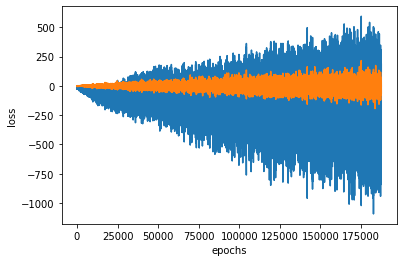

In [9]:
plt.plot(gl_all)
plt.plot(dl_all)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.
plt.show()

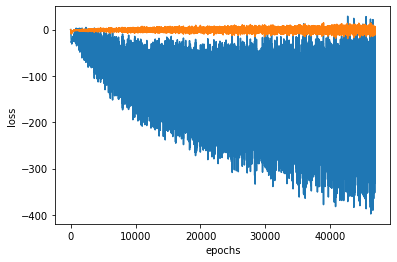

In [8]:
plt.plot(gl_all)
plt.plot(dl_all)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

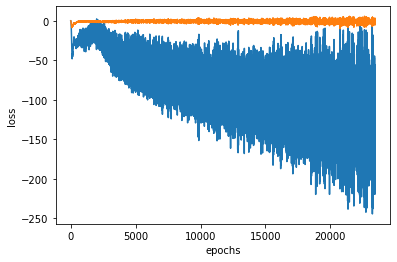

In [10]:
plt.plot(gl_all)
plt.plot(dl_all)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
def defenseGAN_reconstruct(ds_test):
  labels = np.concatenate([y for x, y in ds_test], axis=0)
  
  rec_imgs = 0
  cnt = 0
  for batch, _ in ds_test:
    cnt += 1
    if cnt % 10 == 0:
      print(f'Batch {cnt}')
    start = True
    for i in batch:
      recd_img = reconstruct_single(i)
      if start:
        start = False
        show_2img(i, recd_img)
      rec_imgs = np.append(rec_imgs, recd_img)


  return new_test

def reconstruct_single(img):
  R = 5
  Zs = 7
  Z = []
  aida = 1e-4
  for _ in range(Zs):
    # z = np.random.normal(size=(28,28,1))
    z = tf.random.normal([1,100])
    for i in range(R):
      with tf.GradientTape() as gen_tape:
        gen_tape.watch(z)
        recond = generator(z, training=False)
        diff = tf.math.abs(recond-img)

      grads = gen_tape.gradient(diff, z)
      z = grads*aida + z

    Z.append(z)

  Z_diffs = [tf.math.reduce_euclidean_norm(z).numpy() for z in Z]
  return tf.squeeze(generator(Z[np.argmin(Z_diffs)], training=False), axis=[0])


    

In [21]:
load_and_run('mnist', attack='fgsm', defense='DefenseGAN', epsilon=None)

In [23]:
load_and_run('mnist')

# Defensive Distillation 
Papernot et al. [[2]](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7546524)

# MagNet
Meng and Chen 2017 [[3]](https://arxiv.org/pdf/1705.09064.pdf)

#PersistentResults
module to save data to file


In [ ]:
# add new key and reintialize PersistentResults to add new array 
data_lines = [
              # No Defense
              'mnist_fgsm',
              'mnist_fgsm_box',
              'cifar_fgsm',
              'cifar_fgsm_box',
              'fashion_fgsm',
              'fashion_fgsm_box',

              ### Fashion Dataset by Default###
              # fgsm vs adversarial training
              'training_vs_fgsm',
              'training_vs_fgsm_box',
              'trainingR_vs_fgsm',
              'trainingR_vs_fgsm_box',

              # fgsm 2 vs adversarial training
              'training_vs_fgsm2',
              'training_vs_fgsm2_box',
              'training5_vs_fgsm2',
              'training5_vs_fgsm2_box',
              'training20_vs_fgsm2',
              'training20_vs_fgsm2_box',
              'trainingf14_vs_fgsm2',
              'trainingf14_vs_fgsm2_box',

              # fgsm vs DefenseGAN
              'DGAN_vs_fgsm',

]
data_lines2d = [
                # Query Strength
                'fashion_qs',
                'mnist_qs',
                'cifar_qs',

                # Adversarial Training Iterations
                'fashion_it',
                'fashion_box_it',
]

### Download and initialize 'PersistentResults'
all new data will be lost

In [ ]:
epsilon = [.001,.005, .01, .03, .05, .07, .1]
results_link = 'https://raw.githubusercontent.com/WesRobbins/AdversarialML/main/results.csv'
arry_link = 'https://raw.githubusercontent.com/WesRobbins/AdversarialML/main/arrys.py'
urllib.request.urlretrieve(results_link, 'results.csv')
urllib.request.urlretrieve(arry_link, 'arry.py')
sns.set_style('whitegrid')
import arry
reload(arry)
saved = arry.PersistentResults(data_lines, data_lines2d)

### Just Initialize 'PersistentResults'
all new data will be lost unless written to 'results'



In [ ]:
import arry
epsilon = [.001,.005, .01, .03, .05, .07, .1]
reload(arry)
saved = arry.PersistentResults(data_lines, data_lines2d)

### Load data from 'results' file

In [ ]:
saved.read_results()

### Write Results to 'results' file

In [ ]:
saved.diff()

The folling keys would be updated in case of a write:
------------------------------------------------------
Key: training5_vs_fgsm2 - In memory: Filled In File: Filled
Key: training5_vs_fgsm2_box - In memory: Filled In File: Filled


In [ ]:
saved.write_all()

mnist_fgsm was written
mnist_fgsm_box was written
cifar_fgsm was written
cifar_fgsm_box was written
fashion_fgsm was written
fashion_fgsm_box was written
training_vs_fgsm was written
training_vs_fgsm_box was written
trainingR_vs_fgsm was written
trainingR_vs_fgsm_box was written
training_vs_fgsm2 was written
training_vs_fgsm2_box was written
training5_vs_fgsm2 was written
training5_vs_fgsm2_box was written
training20_vs_fgsm2 was written
training20_vs_fgsm2_box was written
trainingf20_vs_fgsm2 was written
trainingf20_vs_fgsm2_box was written
fashion_qs_QS100 was written
fashion_qs_QS500 was written
fashion_qs_QS1000 was written
fashion_qs_QS3000 was written
fashion_qs_QS5000 was written
fashion_qs_QS15000 was written
fashion_qs_QS30000 was written
fashion_qs_QSNone was written
mnist_qs_QS100 was written
mnist_qs_QS500 was written
mnist_qs_QS1000 was written
mnist_qs_QS3000 was written
mnist_qs_QS5000 was written
mnist_qs_QS15000 was written
mnist_qs_QS30000 was written
mnist_qs_QSNone 

### Show arrays in Memory

In [ ]:
saved.show_arrys()

mnist_fgsm: Correct
mnist_fgsm_box: Correct
cifar_fgsm: Correct
cifar_fgsm_box: Correct
fashion_fgsm: Correct
fashion_fgsm_box: Correct
training_vs_fgsm: Correct
training_vs_fgsm_box: Correct
trainingR_vs_fgsm: Correct
trainingR_vs_fgsm_box: Correct
training_vs_fgsm2: Correct
training_vs_fgsm2_box: Correct
training5_vs_fgsm2: Correct
training5_vs_fgsm2_box: Correct
training20_vs_fgsm2: Correct
training20_vs_fgsm2_box: Correct
trainingf14_vs_fgsm2: Correct
trainingf14_vs_fgsm2_box: Correct
fashion_qs: Correct
mnist_qs: Correct
cifar_qs: Correct
fashion_it: Empty
fashion_box_it: Empty

Correct: 21
Empty: 2
Incorrect amount: 0


In [ ]:
write_all()
from google.colab import files
files.download('results')